Phase_6 — Scaling & Structuring the VLM Pipeline

Step 1 — Setup: install/import and find Drive mount

In [4]:
!pip install --no-cache-dir faiss-cpu -f https://anaconda.org/conda-forge/faiss/files


Looking in links: https://anaconda.org/conda-forge/faiss/files
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 226.2 MB/s eta 0:00:00


In [5]:
import faiss
print("FAISS version:", faiss.__version__)

FAISS version: 1.12.0


In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Phase 6 — Step 1
# Setup: install faiss (Colab-safe), import libs, detect Drive path

import os, sys, subprocess

# Try import faiss; install if missing
try:
    import faiss
except Exception:
    print("Installing faiss (via conda-forge wheel, works with Python 3.12)...")
    subprocess.check_call([
        sys.executable, "-m", "pip", "install",
        "--no-cache-dir", "faiss-cpu",
        "-f", "https://anaconda.org/conda-forge/faiss/files"
    ])
    import faiss

print("FAISS version:", faiss.__version__)

# Standard imports
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from transformers import CLIPProcessor, CLIPModel

# Detect Drive mountpoint (works with /content/drive or /content/gdrive)
drive_candidates = ["/content/drive/MyDrive", "/content/gdrive/MyDrive", "/mnt/data/MyDrive"]
drive_root = None
for c in drive_candidates:
    if os.path.exists(c):
        drive_root = c.replace("/MyDrive","")
        break

if drive_root is None:
    print("No Google Drive mount detected in common locations. If you are using Colab, mount your drive first.")
else:
    print("Detected Drive root:", drive_root)

# Base project path (change if your repo path differs)
BASE = os.path.join(drive_root, "MyDrive", "Emach-Structures-ML-Portfolio") if drive_root else "/content"
print("Base path (project root):", BASE)

# Phase folders we will scan for images
PHASE_FOLDERS = [
    "Phase1_Setup_Foundation",
    "Phase2_VLM",
    "Phase3_HighPerf_CV",
    "Phase4_LLM",
    "Phase5_Colab",
    "Phase6_Portfolio"
]
PHASE_FOLDERS = [os.path.join(BASE, p) for p in PHASE_FOLDERS]


FAISS version: 1.12.0
Detected Drive root: /content/drive
Base path (project root): /content/drive/MyDrive/Emach-Structures-ML-Portfolio


Step 2 — Discover image files across phase folders

In [10]:
# Step 2 — Find image files under the project phases
# This will collect common image extensions recursively.

img_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp")
image_paths = []

for phase_path in PHASE_FOLDERS:
    if not os.path.isdir(phase_path):
        continue
    for root, _, files in os.walk(phase_path):
        for f in files:
            if f.lower().endswith(img_exts):
                image_paths.append(os.path.join(root, f))

# Sort for deterministic order
image_paths = sorted(image_paths)
print(f"Found {len(image_paths)} images across phases.")
if len(image_paths) > 10:
    print("Sample:", image_paths[:5])
else:
    print("Images:", image_paths)

Found 4 images across phases.
Images: ['/content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase5_Colab/sample_images/03e0a9d3-2bcd0000.jpg', '/content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase5_Colab/sample_images/6b2591b3-1ccc5250.jpg', '/content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase5_Colab/sample_images/6c0f4b52-fed90df4.jpg', '/content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase5_Colab/sample_images/99fda8cc-278dda16.jpg']


Step 3 — Load CLIP model & processor (device aware)

In [11]:
# Step 3 — Load CLIP (PyTorch) and set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

clip_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(clip_model_name)
clip = CLIPModel.from_pretrained(clip_model_name).to(device)
clip.eval()
print("CLIP loaded:", clip_model_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP loaded: openai/clip-vit-base-patch32


Step 4 — Batch-encode images and save embeddings + metadata

In [12]:
# Step 4 — Batch encode all images and save embeddings + metadata
# This may take time depending on number of images and device.

out_dir = os.path.join(BASE, "Phase6_VLM")
os.makedirs(out_dir, exist_ok=True)
emb_file = os.path.join(out_dir, "image_embeddings.npy")
meta_file = os.path.join(out_dir, "image_metadata.csv")

BATCH = 32  # adjust for memory (use 64+ on good GPUs)
n = len(image_paths)
if n == 0:
    raise RuntimeError("No images found. Make sure your project folders contain images.")

# If embeddings already exist, skip computation
if os.path.exists(emb_file) and os.path.exists(meta_file):
    print("Embeddings + metadata already exist. To recompute, remove:", emb_file, meta_file)
else:
    all_embs = []
    metas = []
    for i in tqdm(range(0, n, BATCH), desc="Encoding images"):
        batch_paths = image_paths[i:i+BATCH]
        pil_imgs = []
        for p in batch_paths:
            try:
                img = Image.open(p).convert("RGB")
                pil_imgs.append(img)
            except Exception as e:
                print("Failed to open", p, ":", e)
                pil_imgs.append(Image.new("RGB", (224,224), (127,127,127)))
        # processor returns pixel_values; move to device
        inputs = processor(images=pil_imgs, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            feats = clip.get_image_features(**inputs)  # (B, D)
        feats = feats.cpu().numpy().astype(np.float32)
        all_embs.append(feats)
        for p in batch_paths:
            # derive phase from path if possible
            phase_name = None
            for phase in PHASE_FOLDERS:
                if p.startswith(phase):
                    phase_name = os.path.basename(phase)
                    break
            metas.append({"file_path": p, "file_name": os.path.basename(p), "phase": phase_name})
    all_embs = np.vstack(all_embs)
    print("Embeddings shape:", all_embs.shape)
    np.save(emb_file, all_embs)
    pd.DataFrame(metas).to_csv(meta_file, index=False)
    print("Saved embeddings to:", emb_file)
    print("Saved metadata to:", meta_file)

Encoding images: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

Embeddings shape: (4, 512)
Saved embeddings to: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase6_VLM/image_embeddings.npy
Saved metadata to: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase6_VLM/image_metadata.csv


Step 5 — Build FAISS index and save it

In [13]:
# Step 5 — Build FAISS index for cosine similarity (use inner-product on normalized vectors)
emb_file = os.path.join(out_dir, "image_embeddings.npy")
meta_file = os.path.join(out_dir, "image_metadata.csv")
index_file = os.path.join(out_dir, "faiss_index.bin")

embs = np.load(emb_file)  # (N, D)
N, D = embs.shape
print("Loaded embeddings:", embs.shape)

# Normalize embeddings (L2) to use inner product as cosine similarity
norms = np.linalg.norm(embs, axis=1, keepdims=True)
norms[norms==0] = 1.0
embs_normalized = embs / norms

# Build IndexFlatIP (fast, exact)
index = faiss.IndexFlatIP(D)  # inner product
index.add(embs_normalized)    # add vectors
print("FAISS index built. n_total =", index.ntotal)

# Save index
faiss.write_index(index, index_file)
print("Saved FAISS index to:", index_file)

Loaded embeddings: (4, 512)
FAISS index built. n_total = 4
Saved FAISS index to: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase6_VLM/faiss_index.bin


Step 6 — Helper functions: search by image, search by text

In [14]:
# Step 6 — Search helpers

# Load metadata
meta_df = pd.read_csv(meta_file)

# Load index from disk (if desired)
if 'index' not in globals():
    index = faiss.read_index(index_file)

def search_by_image(img_path, top_k=5):
    # load and encode single image
    img = Image.open(img_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        q = clip.get_image_features(**inputs).cpu().numpy().astype(np.float32)
    # normalize
    q = q / (np.linalg.norm(q, axis=1, keepdims=True) + 1e-8)
    _, I = index.search(q, top_k)
    results = []
    for idx in I[0]:
        results.append((int(idx), meta_df.iloc[int(idx)].file_path, float(np.dot(q[0], embs_normalized[int(idx)]))))
    return results

def search_by_text(text, top_k=5):
    # encode text with CLIP text encoder
    text_inputs = processor(text=[text], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k,v in text_inputs.items()}
    with torch.no_grad():
        q = clip.get_text_features(**text_inputs).cpu().numpy().astype(np.float32)
    q = q / (np.linalg.norm(q, axis=1, keepdims=True) + 1e-8)
    _, I = index.search(q, top_k)
    results = []
    for idx in I[0]:
        results.append((int(idx), meta_df.iloc[int(idx)].file_path, float(np.dot(q[0], embs_normalized[int(idx)]))))
    return results

# Example quick usage (will run fast)
if N>0:
    print("Example search by text ->", search_by_text("rusty metal", top_k=3))

Example search by text -> [(2, '/content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase5_Colab/sample_images/6c0f4b52-fed90df4.jpg', 0.22560150921344757), (3, '/content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase5_Colab/sample_images/99fda8cc-278dda16.jpg', 0.2174215018749237), (0, '/content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase5_Colab/sample_images/03e0a9d3-2bcd0000.jpg', 0.2023983597755432)]


Step 7 — Evaluation: Self-retrieval Recall@K & basic stats

In [15]:
# Step 7 — Evaluate self-retrieval (each image queries and should find itself)
# This is a simple sanity metric: recall@K where ground-truth is identity.

def compute_recall_at_k(k_list=[1,5,10]):
    recalls = {k: 0 for k in k_list}
    # for efficiency, search batches of queries
    batch_q = 64
    for i in range(0, N, batch_q):
        q_embs = embs_normalized[i:i+batch_q]
        # index.search expects shape (M, D)
        _, I = index.search(q_embs, max(k_list))
        for j, idx_row in enumerate(I):
            global_idx = i + j
            for k in k_list:
                topk = idx_row[:k]
                if global_idx in topk:
                    recalls[k] += 1
    totals = N
    recalls_pct = {k: recalls[k] / totals for k in recalls}
    return recalls_pct

recalls = compute_recall_at_k([1,5,10])
print("Self-retrieval recall:", recalls)

# Additional statistics
avg_norm = np.mean(np.linalg.norm(embs, axis=1))
print(f"Average raw embedding norm: {avg_norm:.3f}")

Self-retrieval recall: {1: 1.0, 5: 1.0, 10: 1.0}
Average raw embedding norm: 10.113


Step 8 — Save reports

In [16]:
# Step 8 — Save simple report with recall metrics and top-k examples
report = {
    "n_images": int(N),
    "embedding_dim": int(D),
    "recall@1": float(recalls.get(1, 0)),
    "recall@5": float(recalls.get(5, 0)),
    "recall@10": float(recalls.get(10, 0)),
}
report_file = os.path.join(out_dir, "phase6_report.json")
import json
with open(report_file, "w") as f:
    json.dump(report, f, indent=2)
print("Saved report:", report_file)

# Save a small CSV of top-3 matches for first 50 images
rows = []
for i in range(min(50, N)):
    q_emb = embs_normalized[i:i+1]
    _, I = index.search(q_emb, 3)
    top = I[0].tolist()
    rows.append({
        "query_index": i,
        "query_file": meta_df.iloc[i].file_path,
        "match_1": meta_df.iloc[top[0]].file_path,
        "match_2": meta_df.iloc[top[1]].file_path if len(top)>1 else "",
        "match_3": meta_df.iloc[top[2]].file_path if len(top)>2 else ""
    })
pd.DataFrame(rows).to_csv(os.path.join(out_dir, "top3_matches_sample.csv"), index=False)
print("Saved top3 sample CSV in:", out_dir)

Saved report: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase6_VLM/phase6_report.json
Saved top3 sample CSV in: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase6_VLM


Step 9 — Example interactive usage (display top-k matches)


Query: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase5_Colab/sample_images/03e0a9d3-2bcd0000.jpg


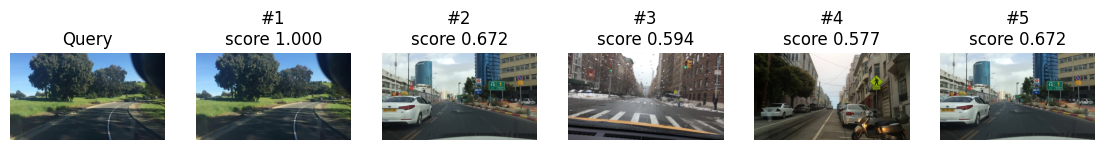


Query: /content/drive/MyDrive/Emach-Structures-ML-Portfolio/Phase5_Colab/sample_images/99fda8cc-278dda16.jpg


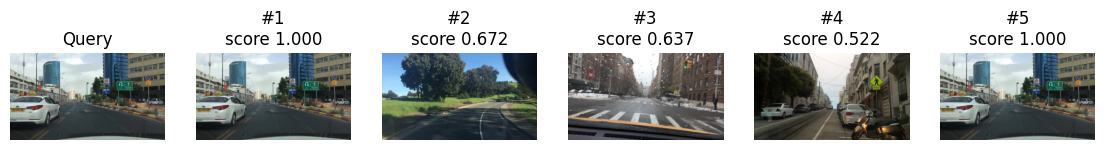

In [17]:
# Step 9 — Show a couple of example queries and display images inline
import matplotlib.pyplot as plt

examples = [0, min(10, N-1)]  # two example indices
for qidx in examples:
    qfile = meta_df.iloc[qidx].file_path
    print("\nQuery:", qfile)
    results = search_by_image(qfile, top_k=5)
    # Display query + matches
    plt.figure(figsize=(14,3))
    # query
    ax = plt.subplot(1, 6, 1)
    im = Image.open(qfile).convert("RGB")
    ax.imshow(im); ax.set_title("Query"); ax.axis("off")
    # matches
    for i, (idx, fpath, score) in enumerate(results):
        ax = plt.subplot(1, 6, i+2)
        im = Image.open(fpath).convert("RGB")
        ax.imshow(im); ax.set_title(f"#{i+1}\nscore {score:.3f}"); ax.axis("off")
    plt.show()